# Image Augmentation 
### Anforderungen:
- tensorflow
- keras
- pillow

für Mac OS User eventuell erforderlich um die Graphen zu plotten:
- conda install nomkl 

## Inhaltsverzeichnis
<ol>
    <li><a href="#einleitung">Einleitung</a></li>
    <li><a href="#schluss">Schlussteil</a></li>
    <li><a href="#quellen">Quellenverzeichnis</a></li>
</ol>

## Einleitung <div id="einleitung" />
- Probleme mit zu kleinem Datenset => führte zu Overfitting
- wie man Overfitting erkennt
- welche Maßnahmen es gegen Overfitting gibt

Overfitting bezieht sich auf ein Model, das den Trainingsdatensatz zu gut gelernt hat, einschließlich des statistischen Rauschens oder zufälliger Schwankungen im Trainingsdatensatz.

![test](../assets/overfitting.jpeg)
_Abbildung 1: Beispielkurve für Overfitting aus dem Training für Hunderassenklassifizierung_

### Import der Bibliotheken

In [9]:
import urllib

import tensorflow as tf
# from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_datasets as tfds

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

## Beispiel Image Augmentation mit Tensorflow

Importieren einen Bildes

In [ ]:
image_path = tf.keras.utils.get_file("good_boy.jpg", "https://raw.githubusercontent.com/MajusLenz/Dogspiracy-machine-learning/master/data/images/predict/good_boy.jpg")
Image.open(image_path)


Das Bild wird in Tensorflow Format konvertiert:

In [ ]:
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)

Über eine Funktion kann das Originalbild mit dem augmentierten Bild verglichen werden:

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)


Das Bild drehen:

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

Saturation

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)


Helligkeit:

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

Kontrast:

In [ ]:
contrast = tf.image.adjust_contrast(image, 2)
visualize(image, contrast)

Rotation

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

Crop

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.6)
visualize(image,cropped)


In [ ]:
quality = tf.image.adjust_jpeg_quality(image, 20)
visualize(image,quality)

## Image Augmentation am Beispiel vom MNIST Datensatz

In diesem Abschnitt wird der MNIST-Datensatz mit handgeschriebene Ziffern verwendet. MNIST enthält einen Trainingsdatensatz mit 60.000 Bildern und einen Testdatensatz mit 10.000 Bildern. Die Ziffern wurden größennormalisiert und in einem Bild mit fester Größe zentriert.

_"It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting."_ 

[MINST Webseite](http://yann.lecun.com/exdb/mnist/) 

Im Kontext des Jupyter Nodebooks wurde sich deshalb entschieden diesen Datensatz zu verwenden, um eine schnelle Ausführbarkeit und Experimentieren mit Parametern zu ermöglichen. Über das Package _tensorflow_datasets_ gibt es die Möglichkeit vorgefertigte Datensets herunterzuladen.

Im folgenden wird das Datenset geladen und die Form des Datensatzes ausgegeben:

In [34]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

print("Größe des Trainingsdatensatzes: "+ str(info.splits['train'].num_examples))
print("Größe des Testdatensatzes: "+ str(info.splits['test'].num_examples))
print(info.features['image'])
print(info.features['label'])

Größe des Trainingsdatensatzes: 60000
Größe des Testdatensatzes: 10000
Image(shape=(28, 28, 1), dtype=tf.uint8)
ClassLabel(shape=(), dtype=tf.int64, num_classes=10)


Aus den Ziffern 0 bis 9 ergeben sich 10 Klassen. Die Bilder haben die Form 28x28 Pixel und sind in Graustufen.

### Augmentierung

Da die Bilder des MNIST Datensatzen in Graustufen vorliegen, ergibt es keinen Sinn random_saturation zu nutzen. Außerdem sollte auch Spiegelung (flip_left_right) nicht eingesetzt werden, da das CNN sonst gespiegelte Zahlen lernt. 

In [35]:
def augment(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    
  return image,label

### Vorbereitung des Trainings 

Über eine Hilfsmethode werden die Bilder normalisiert. Um Overfitting zu erzeugen wird nur ein Subset des Datensets zum Trainieren verwendet.

In [36]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

BATCH_SIZE = 64
NUM_SUBSET = 2048

augmented_train_batches = (
    train_dataset
    .take(NUM_SUBSET)
    .cache()
    .shuffle(num_train_examples//4)
    .map(augment, num_parallel_calls=AUTOTUNE) # mit Augmentation
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

non_augmented_train_batches = (
    train_dataset
    .take(NUM_SUBSET)
    .cache()
    .shuffle(num_train_examples//4)
    .map(convert, num_parallel_calls=AUTOTUNE) # ohne Augmentation
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

### Model

In [5]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

### Training im Vergleich

In [8]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=5, validation_data=validation_batches)

model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=5, validation_data=validation_batches)

Epoch 1/20
32/32 [==============================] - 16s 507ms/step - loss: 0.8278 - accuracy: 0.7598 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 16s 509ms/step - loss: 0.2165 - accuracy: 0.9360 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 16s 509ms/step - loss: 0.1114 - accuracy: 0.9673 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 16s 500ms/step - loss: 0.0467 - accuracy: 0.9873 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 17s 518ms/step - loss: 0.0637 - accuracy: 0.9751 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 17s 520ms/step - loss: 0.0368 - accuracy: 0.9849 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 16s 515ms/step - loss: 0.0367 - accuracy: 

Plotten der Ergebnisse:

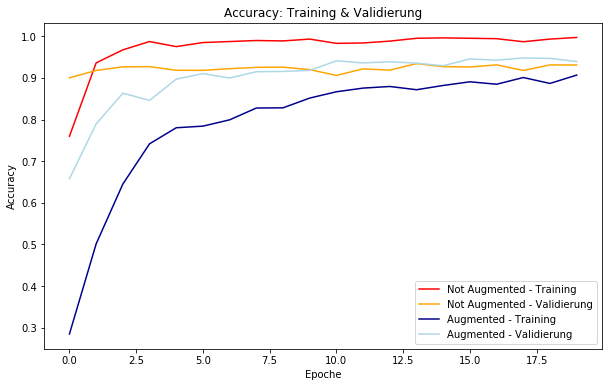

In [11]:
# Ausgabe des Trainingsverlaufs als Diagramm
plt.figure(figsize = (10, 6))
plt.plot(range(5), no_aug_history.history["accuracy"], "red", label = "Not Augmented - Training")
plt.plot(range(5), no_aug_history.history["val_accuracy"], "orange", label = "Not Augmented - Validierung")
plt.plot(range(5), aug_history.history["accuracy"], "darkblue", label = "Augmented - Training")
plt.plot(range(5), aug_history.history["val_accuracy"], "lightblue", label = "Augmented - Validierung")
plt.title("Accuracy: Training & Validierung")
plt.ylabel("Accuracy")
plt.xlabel("Epoche")
plt.legend()
plt.show()

## Schlussteil <div id="schluss" />

## Quellenverzeichnis <div id="quellen" />
- https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
- https://www.tensorflow.org/tutorials/images/data_augmentation
- https://www.tensorflow.org/datasets/overview
- http://yann.lecun.com/exdb/mnist/